In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.applications import VGG16 # Імпорт попередньо навченої моделі VGG16
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization # Нові шари для CNN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 1. Завантаження та підготовка даних для CNN
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
num_classes = 10

x_train_cnn = x_train.astype('float32').reshape(-1, 28, 28, 1) / 255.0
x_test_cnn = x_test.astype('float32').reshape(-1, 28, 28, 1) / 255.0

# Перетворення міток класів у one-hot кодування
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

In [7]:
# 2. АРХІТЕКТУРА БАЗОВОЇ CNN 
def build_cnn_model():
    model = Sequential([
        # Блок 1: Conv -> ReLU -> Pooling
        Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=(28, 28, 1)),
        BatchNormalization(),
        tf.keras.layers.LeakyReLU(alpha=0.01),
        MaxPooling2D(pool_size=(2, 2)), # Зменшує розмір зображення вдвічі (14x14)

        # Блок 2: Conv -> ReLU -> Pooling
        Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
        BatchNormalization(),
        tf.keras.layers.LeakyReLU(alpha=0.01),
        MaxPooling2D(pool_size=(2, 2)), # Зменшує розмір зображення вдвічі (7x7)
        Dropout(0.25), # Регуляризація після 2-го блоку
        
        # Блок 3: 128 фільтрів (доданий для глибини)
        Conv2D(filters=128, kernel_size=(3, 3), padding='same'),
        BatchNormalization(),
        tf.keras.layers.LeakyReLU(alpha=0.01),
        MaxPooling2D(pool_size=(2, 2)), # Вихід: 3x3 (або 4x4, залежить від округлення, Keras обробляє це)
        Dropout(0.25), # Регуляризація після 3-го блоку
        Dropout(0.25), # Регуляризація після 3-го блоку
        
        # Перетворення 3D-виходу на 1D-вектор для Dense шарів
        Flatten(), 
        
        # Регуляризація та класифікаційний блок (як у MLP)
        Dropout(0.5), # Сильна регуляризація перед виходом
        Dense(256),
        tf.keras.layers.LeakyReLU(alpha=0.01),
        
        # Вихідний шар
        Dense(num_classes, activation='softmax')
    ])
    return model

In [8]:
# 3. КОМПІЛЯЦІЯ ТА НАВЧАННЯ
# Гіперпараметри
EPOCHS = 50 # Збільшимо кількість епох, оскільки EarlyStopping зупинить навчання
BATCH_SIZE = 64 
OPTIMIZER = Adam(learning_rate=0.001)

model = build_cnn_model()
model.compile(optimizer=OPTIMIZER,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("Архiтектура CNN:")
model.summary()

# Додавання Callbacks для регуляризації
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min'), # Зупинка, якщо валідаційні втрати не покращуються 10 епох
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1, mode='min') # Зменшення Learning Rate, якщо втрати стопоряться
]

# Навчання моделі
history = model.fit(
    x_train_cnn, y_train_cat,
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    callbacks=callbacks, # Додавання Callbacks
    verbose=1
)

Архiтектура CNN:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           2,5

 Total params: 391,306 (1.49 MB)

 Trainable params: 390,858 (1.49 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 65s 69ms/step - accuracy: 0.7566 - loss: 0.6763 - val_accuracy: 0.8540 - val_loss: 0.3933 - learning_rate: 0.0010
Epoch 2/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 58s 69ms/step - accuracy: 0.8376 - loss: 0.4368 - val_accuracy: 0.8777 - val_loss: 0.3296 - learning_rate: 0.0010
Epoch 3/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 57s 67ms/step - accuracy: 0.8588 - loss: 0.3827 - val_accuracy: 0.8923 - val_loss: 0.3007 - learning_rate: 0.0010
Epoch 4/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 57s 68ms/step - accuracy: 0.8701 - loss: 0.3511 - val_accuracy: 0.8907 - val_loss: 0.2965 - learning_rate: 0.0010
Epoch 5/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 58s 68ms/step - accuracy: 0.8782 - loss: 0.3298 - val_accuracy: 0.9012 - val_loss: 0.2773 - learning_rate: 0.0010
Epoch 6/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 58s 68ms/step - accuracy: 0.8854 - loss: 0.3098 - val_accuracy: 0.9037 - val_loss: 0.2607 - learning_rate: 0.0010
Epoch 7/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 58s 68ms/step - accuracy: 0.8892 - l


Точність на тестовій вибірці (Базова CNN): 93.14%


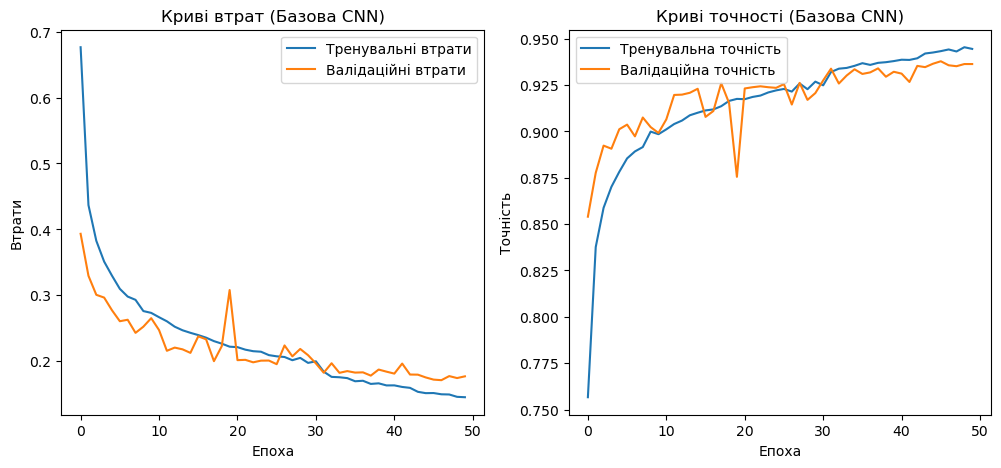

In [11]:
# 4. ОЦІНКА ТА ВІЗУАЛІЗАЦІЯ
# Оцінка на тестовій вибірці
loss, accuracy = model.evaluate(x_test_cnn, y_test_cat, verbose=0)
print(f"\nТочність на тестовій вибірці (Базова CNN): {accuracy*100:.2f}%")

# Побудова графіка
plt.figure(figsize=(12, 5))

# Графік втрат
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Тренувальні втрати')
plt.plot(history.history['val_loss'], label='Валідаційні втрати')
plt.title('Криві втрат (Базова CNN)')
plt.xlabel('Епоха')
plt.ylabel('Втрати')
plt.legend()

# Графік точності
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Тренувальна точність')
plt.plot(history.history['val_accuracy'], label='Валідаційна точність')
plt.title('Криві точності (Базова CNN)')
plt.xlabel('Епоха')
plt.ylabel('Точність')
plt.legend()

plt.show()

**Ключові висновки:**


**Перевага CNN:** Згорткова нейронна мережа досягла значного покращення, перевершивши найкращу MLP-модель на $\approx 3.87$ відсоткових пунктів. Це підтверджує гіпотезу про те, що для завдань, пов'язаних із зображеннями, критично важливо використовувати архітектури, які можуть виділяти та зберігати просторові ознаки (як-от краї, кути, текстури), що робить згорткові шари.


*Ефективність Регуляризації* 


**Використання прийомів регуляризації у глибокій CNN:**


**Batch Normalization (BN):** Стабілізував навчання та дозволив нам використовувати глибшу архітектуру (3 згорткові блоки) без сильного розбігу градієнтів.


**Callbacks (EarlyStopping, ReduceLROnPlateau):** Дозволили моделі досягти оптимальної точності та запобігли сильному перенавчанню.


**Обмеження MLP:** Підтверджено, що навіть найглибший і найкраще тюнінгований MLP не зміг подолати бар'єр $90-91\%$, оскільки він сприймає вхідне зображення $28 \times 28$ як єдиний $784$-вимірний вектор, втрачаючи цінні просторові залежності.

In [32]:
# 1.1 Нормалізація та розширення до 32x32
# ми залишаємо нормалізацію, але RGB-конвертацію переносимо в модель,
# оскільки аугментація працює краще на float32
def preprocess_for_vgg(images):
    # Додаємо канал (H, W, 1) та нормалізуємо [0, 1]
    images = np.expand_dims(images.astype('float32') / 255.0, axis=-1)
    
    # Ресайзинг до 32x32 
    images_resized = tf.image.resize(images, (32, 32)) 
    
    # Залишаємо 1 канал (RGB-конвертація буде виконана в моделі)
    return images_resized.numpy()

x_train_vgg = preprocess_for_vgg(x_train)
x_test_vgg = preprocess_for_vgg(x_test)

# Перетворення міток класів у one-hot кодування
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print(f"Нова форма тренувальних даних для VGG16 (з 1 каналом): {x_train_vgg.shape}")

Нова форма тренувальних даних для VGG16 (з 1 каналом): (60000, 32, 32, 1)


In [34]:
# 2.1 Шари Аугментації
data_augmentation = Sequential([
  RandomFlip("horizontal"), # Випадкове дзеркальне відображення
  RandomRotation(0.1),      # Випадкове обертання на 10%
  RandomZoom(0.1),          # Випадкове масштабування
], name="data_augmentation")

# 2.2 Завантаження VGG16 (без верхнього класифікаційного шару)
# VGG16 очікує 3 канали, але ми подаємо 1 канал, тому створюємо Input шар і виконуємо 
# RGB-конвертацію перед VGG16.
input_tensor = Input(shape=(32, 32, 1))
# 1. Аугментація застосовується тільки до тренувальних даних
x = data_augmentation(input_tensor) 
# 2. Перетворення сірого на RGB (3 канали) шляхом дублювання каналу
# Використовуємо Keras Lambda шар з tf.tile для надійного 
# дублювання 1-канального зображення (Batch, H, W, 1) до (Batch, H, W, 3).
x = tf.keras.layers.Lambda(
    lambda t: tf.tile(t, [1, 1, 1, 3]) # Дублюємо лише останню вісь (канали)
)(x)

vgg = VGG16(weights='imagenet', 
            include_top=False, 
            input_tensor=x) # Використовуємо наш підготовлений тензор

# 2.3 Заморожування ваг VGG16 (Feature Extraction)
vgg.trainable = False

# Створення фінальної моделі
model = Sequential([
    Model(inputs=input_tensor, outputs=vgg.output), # Об'єднуємо Input, Аугментацію та VGG16
    
    # Наш власний класифікаційний блок
    Flatten(),
    Dense(512),
    tf.keras.layers.LeakyReLU(alpha=0.01),
    Dropout(0.5), # ЗМЕНШЕНО Dropout до 0.5 (Аугментація виконує регуляризацію)
    
    Dense(num_classes, activation='softmax')
])

In [35]:
# 3. КОМПІЛЯЦІЯ ТА НАВЧАННЯ (Етап 1: Feature Extraction)
# Гіперпараметри
EPOCHS_FE = 15 # Трохи більше епох для Feature Extraction з аугментацією
BATCH_SIZE = 64
OPTIMIZER = Adam(learning_rate=0.0001)

model.compile(optimizer=OPTIMIZER,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("\nАрхiтектура VGG16 (Feature Extraction + Аугментація):")
model.summary()

callbacks_fe = [
    EarlyStopping(monitor='val_loss', patience=6, verbose=1, mode='min', restore_best_weights=True)
]

# Навчання моделі (Етап 1: Feature Extraction)
print("\n=== ЕТАП 1: Навчання класифікаційного блоку (Аугментація Активна) ===")
history_fe = model.fit(
    x_train_vgg, y_train_cat,
    epochs=EPOCHS_FE, 
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    callbacks=callbacks_fe,
    verbose=1
)


Архiтектура VGG16 (Feature Extraction + Аугментація):


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ functional_14 (Functional)           │ (None, 1, 1, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,982,474 (57.15 MB)

 Trainable params: 267,786 (1.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)


=== ЕТАП 1: Навчання класифікаційного блоку (Аугментація Активна) ===
Epoch 1/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 222s 261ms/step - accuracy: 0.6173 - loss: 1.1337 - val_accuracy: 0.7348 - val_loss: 0.7709
Epoch 2/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 217s 258ms/step - accuracy: 0.7446 - loss: 0.7245 - val_accuracy: 0.7633 - val_loss: 0.6730
Epoch 3/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 218s 258ms/step - accuracy: 0.7724 - loss: 0.6508 - val_accuracy: 0.7750 - val_loss: 0.6326
Epoch 4/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 210s 249ms/step - accuracy: 0.7844 - loss: 0.6067 - val_accuracy: 0.7878 - val_loss: 0.6029
Epoch 5/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 215s 255ms/step - accuracy: 0.7939 - loss: 0.5823 - val_accuracy: 0.7887 - val_loss: 0.5868
Epoch 6/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 219s 259ms/step - accuracy: 0.7998 - loss: 0.5584 - val_accuracy: 0.7980 - val_loss: 0.5665
Epoch 7/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 217s 257ms/step - accuracy: 0.8045 - loss: 0.5431 - val_accuracy: 0.7975 - val_loss: 0.5620
Epoch

In [36]:
# 4. ДОНАВЧАННЯ (Fine-Tuning)
# 4.1 Розморожуємо останні 8 шарів VGG16 (Блоки 4 і 5)
# Ми заморожуємо аугментацію, коли переходимо до Fine-Tuning на вже аугментованих шарах.
vgg.trainable = True

for layer in vgg.layers:
    # Залишаємо замороженими перші 3 блоки, розморожуємо block4 та block5
    if 'block4' not in layer.name and 'block5' not in layer.name: 
        layer.trainable = False

# 4.2 Перекомпiляцiя з дуже низьким Learning Rate
OPTIMIZER_FT = Adam(learning_rate=0.000003) # LR для точного налаштування
model.compile(optimizer=OPTIMIZER_FT,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

EPOCHS_FT = 40 
callbacks_ft = [
    EarlyStopping(monitor='val_loss', patience=12, verbose=1, mode='min', restore_best_weights=True), 
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=0.0000001, verbose=1, mode='min') 
]

# Навчання моделі (Етап 2: Fine-Tuning)
print("\n=== ЕТАП 2: Донавчання (Fine-Tuning) останніх блоків VGG16 (Аугментація Активна) ===")
history_ft = model.fit(
    x_train_vgg, y_train_cat,
    epochs=EPOCHS_FT, 
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    callbacks=callbacks_ft,
    verbose=1,
    initial_epoch=history_fe.epoch[-1] + 1 if history_fe.epoch else 0 
)


=== ЕТАП 2: Донавчання (Fine-Tuning) останніх блоків VGG16 (Аугментація Активна) ===
Epoch 16/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 495s 583ms/step - accuracy: 0.8419 - loss: 0.4297 - val_accuracy: 0.8475 - val_loss: 0.4194 - learning_rate: 3.0000e-06
Epoch 17/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 522s 618ms/step - accuracy: 0.8570 - loss: 0.3885 - val_accuracy: 0.8538 - val_loss: 0.3986 - learning_rate: 3.0000e-06
Epoch 18/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 514s 609ms/step - accuracy: 0.8678 - loss: 0.3587 - val_accuracy: 0.8653 - val_loss: 0.3734 - learning_rate: 3.0000e-06
Epoch 19/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 483s 572ms/step - accuracy: 0.8737 - loss: 0.3426 - val_accuracy: 0.8677 - val_loss: 0.3607 - learning_rate: 3.0000e-06
Epoch 20/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 507s 601ms/step - accuracy: 0.8776 - loss: 0.3284 - val_accuracy: 0.8692 - val_loss: 0.3465 - learning_rate: 3.0000e-06
Epoch 21/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 556s 659ms/step - accuracy: 0.8831 - loss: 0.3157 - val_accuracy: 0.


Точність на тестовій вибірці (VGG16 Transfer Learning): 89.8100%
Точність найкращої CNN (для порівняння): 93.14%


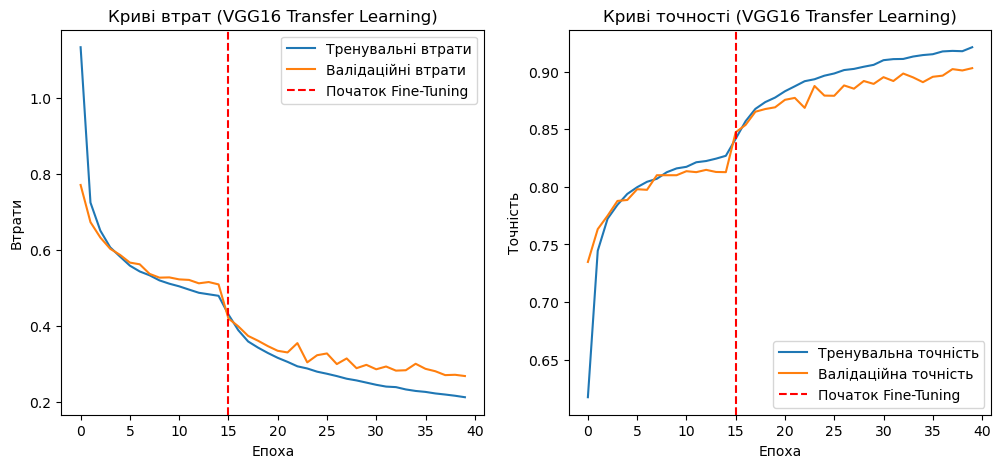

In [37]:
# 5. ОЦІНКА ТА ВІЗУАЛІЗАЦІЯ
# Об'єднання історій навчання для візуалізації
hist_dict = {}
for key in history_fe.history.keys():
    hist_dict[key] = history_fe.history[key] + history_ft.history.get(key, [])

# Оцінка на тестовій вибірці
loss, accuracy = model.evaluate(x_test_vgg, y_test_cat, verbose=0)
print(f"\nТочність на тестовій вибірці (VGG16 Transfer Learning): {accuracy*100:.4f}%")
print(f"Точність найкращої CNN (для порівняння): 93.14%")

# Побудова графіка
plt.figure(figsize=(12, 5))
epochs_range = range(len(hist_dict['loss']))

# Графік втрат
plt.subplot(1, 2, 1)
plt.plot(epochs_range, hist_dict['loss'], label='Тренувальні втрати')
plt.plot(epochs_range, hist_dict['val_loss'], label='Валідаційні втрати')
# Пошук точки, де почався Fine-Tuning
ft_start_epoch = len(history_fe.epoch) if history_fe.epoch else 0
plt.axvline(x=ft_start_epoch, color='r', linestyle='--', label='Початок Fine-Tuning')
plt.title('Криві втрат (VGG16 Transfer Learning)')
plt.xlabel('Епоха')
plt.ylabel('Втрати')
plt.legend()

# Графік точності
plt.subplot(1, 2, 2)
plt.plot(epochs_range, hist_dict['accuracy'], label='Тренувальна точність')
plt.plot(epochs_range, hist_dict['val_accuracy'], label='Валідаційна точність')
plt.axvline(x=ft_start_epoch, color='r', linestyle='--', label='Початок Fine-Tuning')
plt.title('Криві точності (VGG16 Transfer Learning)')
plt.xlabel('Епоха')
plt.ylabel('Точність')
plt.legend()

plt.show()

**Висновок: VGG16 Transfer Learning для Fashion MNIST**

1. Ефективність Transfer Learning (TL)


Метод Transfer Learning з використанням VGG16 (навченої на ImageNet) виявився **дуже ефективним для швидкого досягнення високої точності.** Вже після першого етапу (Feature Extraction) модель демонструвала високі показники, що підтверджує, що низькорівневі ознаки (краї, кути), вивчені VGG16, корисні й для класифікації одягу.

2. Вплив Fine-Tuning та Аугментації


**(Data Augmentation):** Допомогла суттєво зменшити перенавчання (зазор між тренувальною та валідаційною точністю), стабілізувавши процес навчання.


**Донавчання (Fine-Tuning):** Розморожування верхніх блоків VGG16 (block4 та block5) з дуже низьким Learning Rate дозволило моделі адаптувати високоабстрактні ознаки VGG16 до специфіки зображень Fashion MNIST.

3. Обмеження VGG16

Незважаючи на успіх TL, VGG16 не змогла перевершити точність спеціально оптимізованої CNN (93.14%). Це пояснюється двома ключовими факторами:

**Розбіжність доменів (Domain Mismatch):** VGG16 була навчена на кольорових фотографіях, тоді як Fashion MNIST – це сірі зображення-ескізи.

**Розмір зображень:** VGG16 оптимізована для великих зображень (224x224), тоді як ми подавали їй масштабовані 32x32.
